# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing latest HITs](#Reviewing-latest-HITs)
* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
	* [Load previously pickled results](#Load-previously-pickled-results)
	* [Load prior complete dataset if not in memory](#Load-prior-complete-dataset-if-not-in-memory)
	* [Updating full dataset](#Updating-full-dataset)
	* [Working with full dataset](#Working-with-full-dataset)
* [Worker analysis](#Worker-analysis)
	* [Basic worker stats](#Basic-worker-stats)
		* [HIT duration for pricing](#HIT-duration-for-pricing)
	* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
import json
import os

from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes

import pdfextraction.amt_boto_modules as amt_util

# Submitting HITs

## Building URLs for images on s3

In [108]:
book_groups, ranges = amt_util.load_book_info()

daily_sci_urls = amt_util.make_book_group_urls(book_groups, 'daily_sci', ranges)
spectrum_sci_urls = amt_util.make_book_group_urls(book_groups, 'spectrum_sci', ranges)
read_und_sci_urls  = amt_util.make_book_group_urls(book_groups, 'read_und_sci', ranges)
workbook_urls = amt_util.make_book_group_urls(book_groups, 'workbooks', ranges)
misc_urls = amt_util.make_book_group_urls(book_groups, 'misc', ranges)

## submitting HITs in groups

In [117]:
## Switch between sandbox and the real world here ##
## DON'T FORGET to change submission POST request in the client ##

sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = aws_tokes.access_key,
    aws_secret_access_key = aws_tokes.access_secret_key,
    host = real_world_host,
    debug = 1 # debug = 2 prints out all requests.
)
current_account_balance = mturk.get_account_balance()[0]
print current_account_balance # a reminder of sandbox

$619.39


In [5]:
static_params = {
    'title': "Annotate Science Textbook",
    'description': "Choose which category text from a grade-school science book best belongs to",
    'keywords': ['image', 'science', 'text', 'labeling' ],
    'frame_height': 800,
    'amount': 0.06,
    'duration': 3600 * 12,
    'lifetime': 3600 * 24 * 3,
    'max_assignments': 3
}

### creates HITs, careful with this one

In [106]:
pages_to_use = read_und_sci_urls
# pages_to_use = workbook_urls + misc_urls + read_und_sci_urls
expected_cost = len(pages_to_use) *  static_params['amount'] * static_params['max_assignments']
if float(current_account_balance.amount) < expected_cost:
    print('WARNING -- account balance is too low -- WARNING')
print('expect this batch of HITs to cost: $' + str(expected_cost))

WARNING -- account balance is too low -- WARNING
expect this batch of HITs to cost: $408.6


uncomment cell below only when ready to submit

In [820]:
# amt_util.create_hits_from_pages(mturk, pages_to_use, static_params)

# Reviewing latest HITs

In [7]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)
assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch)

In [382]:
print 'current assignment statuses'
print amt_util.get_assignment_statuses(assignment_results_current_batch)

current assignment statuses


Approved    4140
Rejected     141
dtype: int64

The two commands above interact with mechanical turk and can take a while

In [8]:
raw_hit_results_current_batch = amt_util.process_raw_hits(assignment_results_current_batch)

In [9]:
results_df_current_batch = amt_util.make_results_df(raw_hit_results_current_batch)
consensus_results_df_current_batch = amt_util.make_consensus_df(results_df_current_batch, 'No Consensus')

In [10]:
%%capture
no_consensus_hits = consensus_results_df_current_batch[consensus_results_df_current_batch['category'] == 'No Consensus']

In [102]:
flaw_rate = len(no_consensus_hits) / len(consensus_results_df_current_batch)
print 'text boxes without consensus comprise ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

text boxes without consensus comprise 2.87% of the total


In [423]:
amt_util.write_results_df(consensus_results_df_current_batch)

In [419]:
# all pages from the latest batch
pages_to_review =pd.unique(consensus_results_df_current_batch['page'])

In [384]:
# all pages from the latest batch with a no-consensus box
pages_to_review =pd.unique(no_consensus_hits['page'])

In [424]:
sampling_rate = 1
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

amt_util.review_results(to_review)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

sampling 17 pages out of 17
posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


In [438]:
amt_util.count_pages_with_cat(combined_consensus_df, 'Question')

1337

In [73]:
%%capture 
# all pages from the latest batch with a no-consensus box
suspect_subset = results_df_current_batch[results_df_current_batch['worker_id'].isin(suspect_workers[:5])]
amt_util.write_results_df(suspect_subset)
pages_to_review = pd.unique(suspect_subset['page'])

# Merging latest round of HITs into combined dataset 

## Load previously pickled results

In [383]:
batch_number = 7

with open('./store_hit_results_metadata/group_' + str(batch_number) + '/hit_info.pkl') as f:
    r_hits_previous_batch = pickle.load(f)
    
with open('./store_hit_results_metadata/group_' + str(batch_number) + '/assignment_info.pkl') as f:
    assignment_results_previous_batch = pickle.load(f)
    
# with open('./store_hit_results_metadata/group_' + str(batch_number) + '/raw_res.pkl') as f:
#     raw_hit_results_previous_batch = pickle.load(f)

In [397]:
# combined_results_batch = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
# combined_consensus_batch = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')

In [405]:
missing_hits = set(assignment_results_previous_batch.keys()).difference(assignment_results_current_batch.keys())
missing_hits_assignments = {k: v for k, v in assignment_results_previous_batch.items() if k in missing_hits}

## Load prior complete dataset if not in memory

In [2]:
data_pickled_dir = './store_hit_results_metadata/group_latest_combined/' 

In [3]:
combined_results_df = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
combined_consensus_df = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')
combined_consensus_with_workerid_df = pd.read_pickle(data_pickled_dir + 'consensus_df_w_workers.pkl') 

## Updating full dataset

In [426]:
combined_results_df = combined_results_df.append(results_df_previous_batch)
combined_consensus_df = combined_consensus_df.append(consensus_prev)
combined_consensus_with_workerid_df = combined_consensus_with_workerid_df.append(consensus_prevww)

In [4]:
%%capture
no_consensus_hits = combined_consensus_df[combined_consensus_df['category'] == 'No Consensus']

## Working with full dataset

### worker specific

In [961]:
flaw_rate = len(no_consensus_hits) / len(combined_consensus_df)
print 'text boxes without consensus are ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

In [255]:
workers_to_qualify = worker_quality_df[worker_quality_df['submitted'] > 100].sort_values('flaw_ratio', ascending= True).head(25).index.tolist()

In [ ]:
workers_to_qualify

In [242]:
bad_and_prolific_workers[:15]

,submitted,incorrect,flaw_ratio
A2KM2RWXQV47CV,2900.0,2093.0,0.721724
A16EEWCUQK9LM2,1069.0,446.0,0.417212
A1QZHZZMO2TE51,582.0,215.0,0.369416
A2XJH3WC02RMXQ,134.0,87.0,0.649254
AQE7EQDM98KB7,154.0,47.0,0.305195
A18DRAESIN3E94,112.0,43.0,0.383929
A8TDOYC7FWWKR,67.0,36.0,0.537313
A9Y1HKUEOOEPM,49.0,35.0,0.714286
A1EGJ4WHHIU61V,45.0,24.0,0.533333
A1ESKJFDQUMBL4,68.0,23.0,0.338235


workers who contacted me

In [256]:
wrote_me = ['A3T8FDBJQV81FN',
'A3UUH3632AI3ZX',
'A2QVMCGDLTWV9',
'A356GXVAYWN0DV',
'A2V4PRG5UBNIX0',
'A333VJ2K6O6R79']

In [258]:
workers_to_ban = bad_and_prolific_workers[:5].index.tolist()
set(bad_and_prolific_workers.index).intersection(set(wrote_me))

{'A2V4PRG5UBNIX0'}

In [275]:
workers_to_ban

[u'A2KM2RWXQV47CV',
 u'A16EEWCUQK9LM2',
 u'A1QZHZZMO2TE51',
 u'A2XJH3WC02RMXQ',
 u'AQE7EQDM98KB7']

In [260]:
combined_consensus_with_workerid_df.head()

,assignment_id,box_id,category,consensus_category,hit_id,page,worker_id
8126,32AT8R96GLAPAZCI12L4EGDHN25US0,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8144,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6
8162,3N2BF7Y2VQVH7ITTH6IJJSPL15VMHP,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A2RSOGTSR83XKO
8131,32AT8R96GLAPAZCI12L4EGDHN25US0,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8149,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6


After looking through the top few offenders, it's clear that 

1. the very worst intentionally submitted many blank pages

2. the rest didn't read the directions very closely

3. I'm comfortable rejecting the work of those with > 100 submissions

4. I'll ban the worst 15 from future HITs


### Reviewing full dataset

In [94]:
amt_util.write_results_df(combined_consensus_df, local_result_path)

In [4]:
# all pages from the complete
pages_to_review =pd.unique(combined_consensus_df['page'])

In [5]:
combined_consensus_df[combined_consensus_df['category'] == 'Question'].shape

(16986, 4)

In [6]:
pages_to_review =pd.unique(combined_consensus_df[combined_consensus_df['category'] == 'Question']['page'])

In [7]:
# all pages from the complete dataset with a no-consensus box
# pages_to_review =pd.unique(no_consensus_hits['page'])

In [8]:
sampling_rate = 0.30
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 401 pages out of 1337


In [39]:
overmerged_dir = 'labeled-annotations/'
unmerged_dir = 'annotations_ws/'
lessmerged_dir = 'lessmerged-annotations/'
remerged_annotations  = 'test-remerged-annotations/'
anno_dir = lessmerged_dir
amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


In [ ]:
# %%capture 
# # all pages from the latest batch with a no-consensus box

# # suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(bad_and_prolific_to_review[10:15])]
# suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(['A3VE5OH94HYHET'])]
# amt_util.write_results_df(suspect_subset)
# pages_to_review = pd.unique(suspect_subset['page'])

### Sanitizing results- questions marked as answers

In [67]:
question_only_df = combined_consensus_df[combined_consensus_df['category'] == 'Question']

In [68]:
pages_w_questions = pd.unique(question_only_df['page'])
len(pages_w_questions)

1337

In [69]:
combined_df_question_pages_only = combined_consensus_df[combined_consensus_df['page'].isin(pages_w_questions)]

In [111]:
combined_df_question_pages_only.to_pickle('pages_w_questions.pkl')

In [70]:
question_pages_w_answers = pd.unique(combined_df_question_pages_only[combined_df_question_pages_only['category'] == 'Answer']['page'])

In [71]:
question_pages_w_answers.shape

(49,)

In [72]:
incorrectly_marked_answers_df = combined_consensus_df[combined_consensus_df['page'].isin(question_pages_w_answers)]

In [73]:
pd.unique(incorrectly_marked_answers_df['page']).shape

(49,)

In [83]:
to_correct_aq_df = combined_consensus_df[combined_consensus_df['page'].isin(incorrectly_marked_answers_df['page'])]

In [88]:
corrected_aq_df = to_correct_aq_df.replace('Answer', 'Question')

In [105]:
local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_raw_hit_results/'
# local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_unmerged/'

amt_util.write_results_df(corrected_aq_df, local_result_path)

In [106]:
pages_to_review = pd.unique(corrected_aq_df['page'])
sampling_rate = 1
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 49 pages out of 49


In [109]:
# anno_dir = 'corrected_unmerged/'
anno_dir = 'test-remerged-annotations/'

amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


# Worker analysis

## Basic worker stats

In [118]:
print 'number of unique workers:'
pd.unique(combined_results_df['worker_id']).shape[0]

number of unique workers:


185

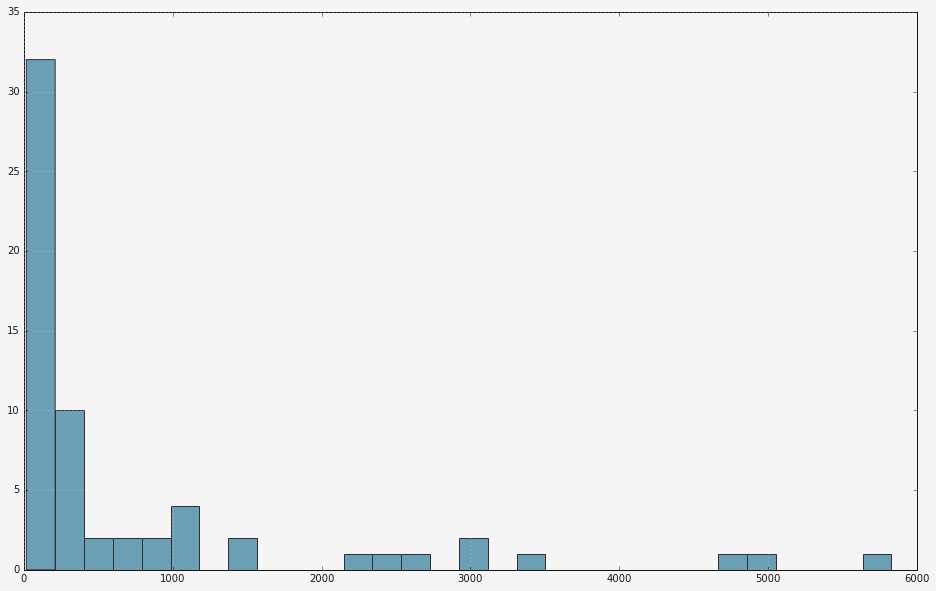

In [565]:
_ = combined_results_df['worker_id'].value_counts().hist(bins= 30)

### HIT duration for pricing

In [27]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [28]:
task_duration_series = pd.Series(task_duration_seconds)

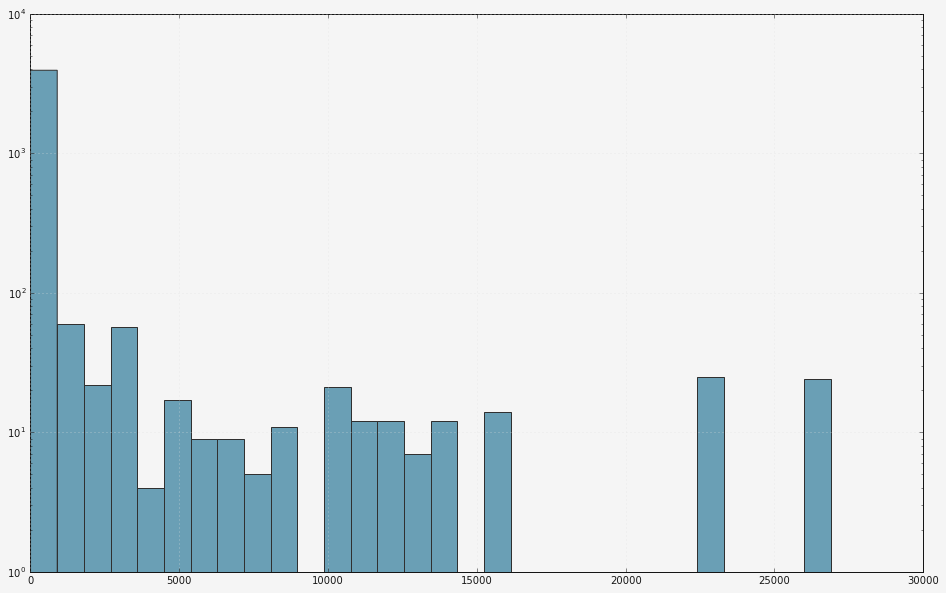

In [872]:
_ = task_duration_series.hist(bins=30, log=True)

In [29]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

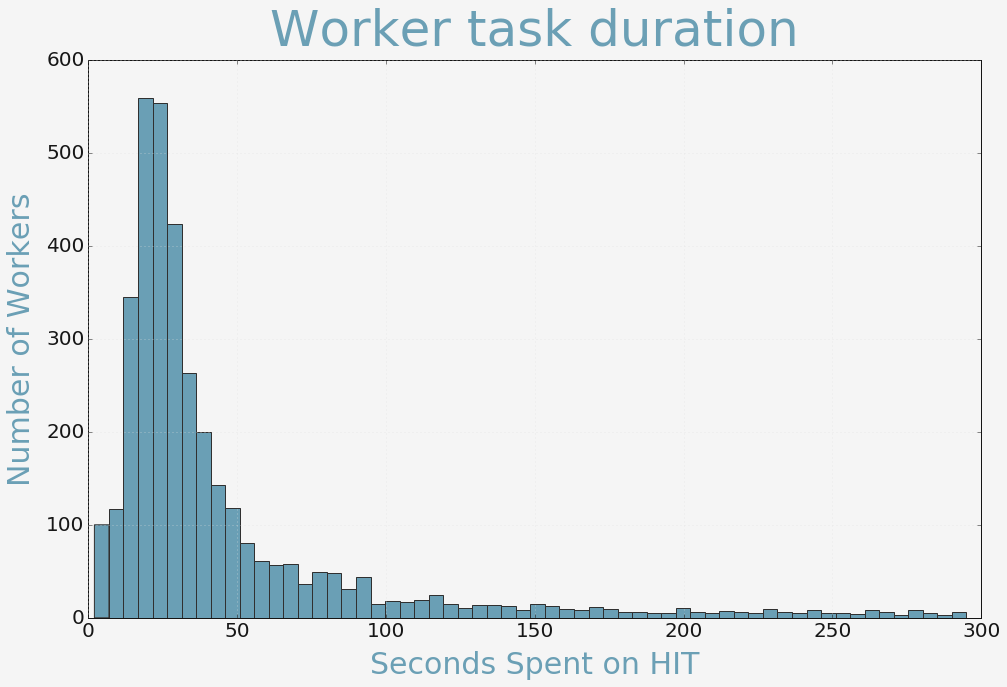

In [34]:
_ = pd.Series(w_duration_series).hist(bins=60)
plt.title('Worker task duration', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Number of Workers", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Seconds Spent on HIT", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [30]:
print 'duration mode= ' + str(w_duration_series.mode().values[0])
print 'duration median= ' + str(w_duration_series.median())

duration mode= 22
duration median= 28.0


## Identifying high and low consensus workers

In [113]:
consensus_with_workerid_df_this_batch = amt_util.make_consensus_df_w_worker_id(results_df_current_batch, consensus_results_df_current_batch)

In [138]:
len(pd.unique(worker_conflicts['worker_id']))

175

In [113]:
worker_conflicts = combined_consensus_with_workerid_df[combined_consensus_with_workerid_df['category'] != combined_consensus_with_workerid_df['consensus_category']]
all_worker_counts = combined_results_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['flaw_ratio'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

good_workers = worker_quality_df.sort_values('flaw_ratio', ascending= True).index.tolist()

suspect_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).index.tolist()

worker_quality_df.sort_values('flaw_ratio', ascending= True).head(10)

,submitted,incorrect,flaw_ratio
A3JOFB6Z65I37Q,124.0,2.0,0.016129
A2HTN7HCNBQ8V4,157.0,3.0,0.019108
A22FK64IWET30E,45.0,1.0,0.022222
AEWGY34WUIA32,1538.0,40.0,0.026008
ASB8T0H7L99RF,507.0,14.0,0.027613
AMA18W8F60Y2J,100.0,3.0,0.030000
A2YY1ZR7Z4VT4M,1517.0,54.0,0.035597
AJFVK3O1D7SPE,1141.0,42.0,0.036810
A10M8ULK8QMRU6,27.0,1.0,0.037037
A2HM35CWB7IIFM,26.0,1.0,0.038462


I became concerned that I missed the perfect performers, but as I suspected perfect workers only did 1-2 HITs at most

In [147]:
aw_set = set(all_worker_counts.index)
bw_set = set(bad_worker_counts.index)
flawless_workers = list(aw_set.difference(bw_set))
all_worker_counts[all_worker_counts.index.isin(best_workers)]

A1N8SWL57W43PV    42
A161I6SGXNY96M    31
A1VL844FUMGC8W    24
A18U9WMYFYJPR6    24
A2U0QL8K0NTGS5    23
A1P47Q6LZPLQ6P    22
A2VL602367WQQW    20
A4UVNGSXE2ANA     20
AFE8IXO7K303F     19
A1HRHFU7KTS0KW    16
Name: worker_id, dtype: int64

In [156]:
bad_and_prolific_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).head(25).sort_values('incorrect', ascending= False)

In [176]:
bad_and_prolific_to_review = list(bad_and_prolific_workers[:15].index)

## Messaging workers

In [118]:
subject = "More science book annotation HITs are available"
message = """
Hello, 

If you're receiving this message you were among the top performers on the first group HITs I submitted.
I've submitted another group of HITs, with more to follow in the next few days. 
This task is slightly different from the first, so please review the new instructions before jumping in.

Happy to get any feedback you might have for the new HITs.
"""

In [119]:
_ = mturk.notify_workers(good_workers[:20], subject, message)

# HIT end-of-life

## Pickle latest results

In [95]:
#reset as needed
# gn = 6

In [375]:
gn

7

In [377]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/group'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_current_batch, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_current_batch, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results_current_batch, temp_store_dir + group_n + raw_results_file_name)
results_df_current_batch.to_pickle(temp_store_dir + group_n + complete_results_file)
consensus_results_df_current_batch.to_pickle(temp_store_dir + group_n + consensus_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

saved HIT batch number 7
now onto batch 8


## Pickle combined dataset

In [429]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

## Accepting and deleting HITs... careful with these

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [321]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [369]:
amt_util.get_assignment_statuses(assignment_results_current_batch_post_reject)

Submitted    4173
Rejected      141
dtype: int64

In [396]:
# amt_util.accept_hits(mturk, assignment_results_current_batch_post)

In [437]:
# amt_util.delete_some_hits(mturk, assignment_results_current_batch_post_)

In [707]:
# amt_util.delete_all_hits(assignment_results_current_batch)